In [1]:
import os
import csv

import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset, RandomSampler
from torchvision import transforms

import cv2
import matplotlib.pyplot as plt

from utils.losses import ArcFace
from backbones.iresnet import iresnet50

from tqdm import tqdm
import pandas as pd

from torch.profiler import profile, record_function, ProfilerActivity

device = "cuda:2" if torch.cuda.is_available() else "cpu"

In [2]:
CHECKPOINTS_PATH_FORMAT = '../checkpoints/{}backbone.pth' # 479 steps per epoch
CASIA_NUM_CLASSES = 10572
NUM_CLASSES = 10
NUM_SAMPLES_PER_CLASS = 10

In [3]:
def get_file_count(directory):
    file_count = 0
    for dirpath, dirnames, filenames in os.walk(directory):
        file_count += len(filenames)
    return file_count

def sort_directories_by_file_count(base_path):
    directories = [
        d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))
    ]
    directories_file_counts = [
        (d, get_file_count(os.path.join(base_path, d))) for d in directories
    ]
    directories_file_counts.sort(key=lambda x: x[1], reverse=True)
    return directories_file_counts

class CasiaWebFace(Dataset):
    def __init__(self, root_dir, local_rank, num_classes=10572, num_samples=None, selective=False):
        super(CasiaWebFace, self).__init__()
        self.transform = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            ]
        )
        self.root_dir = root_dir
        self.local_rank = local_rank
        self.imgidx, self.labels = self.scan(root_dir, num_classes, num_samples, selective)
        self.imageindex = np.array(range(len(self.imgidx)))

    def scan(self, root, num_classes, num_samples, selective):
        imgidex = []
        labels = []
        lb = -1
        list_dir = os.listdir(root)
        list_dir.sort()

        current_num_classes = 0

        if selective:
            directories = sort_directories_by_file_count(root)
        else:
            directories = [(l, len(os.listdir(os.path.join(root, l)))) for l in list_dir]

        for l, file_count in directories:
            if num_classes is not None and current_num_classes >= num_classes:
                break
            
            images = os.listdir(os.path.join(root, l))
            if len(images) < num_samples:
                # Skip classes with fewer than 500 images
                continue

            lb += 1
            for idx, img in enumerate(images):
                if idx >= num_samples:
                    break
                imgidex.append(os.path.join(l, img))
                labels.append(lb)

            current_num_classes += 1

        return imgidex, labels
    
    
    def read_image(self, path):
        return cv2.imread(os.path.join(self.root_dir, path))

    def __getitem__(self, index):
        path = self.imgidx[index]
        imageindex = self.imageindex[index]
        img = self.read_image(path)
        label = self.labels[index]
        label = torch.tensor(label, dtype=torch.long)
        sample = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            sample = self.transform(sample)

        return sample, label, imageindex

    def __len__(self):
        return len(self.imgidx)

In [4]:
full_dataset = CasiaWebFace("/data/ozgur/faces_webface_112x112/casia_training", 0, NUM_CLASSES, NUM_SAMPLES_PER_CLASS, True)
assert len(full_dataset) == NUM_CLASSES * NUM_SAMPLES_PER_CLASS, "Dataset size does not match expected size. Expected: {}, Found: {}".format(
    NUM_CLASSES * NUM_SAMPLES_PER_CLASS, len(full_dataset)
)
random_sampler = RandomSampler(full_dataset)

dl = DataLoader(
    full_dataset,
    sampler=random_sampler,
    batch_size=20,
    num_workers=0,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
)

backbone = iresnet50().to(device)

fc_layer = list(backbone.children())[-2]

header = ArcFace(512, CASIA_NUM_CLASSES).to(device)

criterion = nn.CrossEntropyLoss(reduction="none").to(device)

torch.Size([3, 112, 112]) tensor(4) tensor(45)


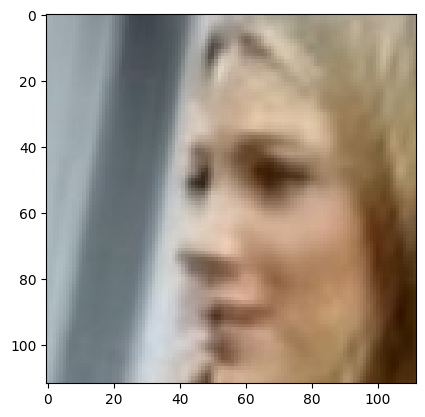

torch.Size([3, 112, 112]) tensor(3) tensor(31)


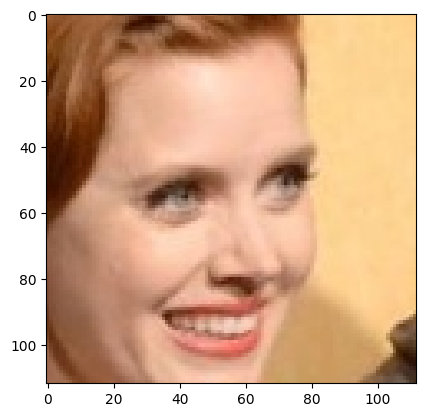

torch.Size([3, 112, 112]) tensor(0) tensor(5)


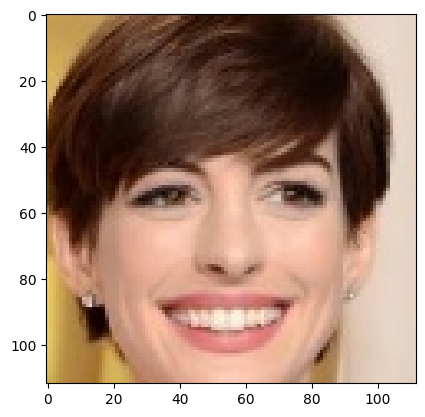

torch.Size([3, 112, 112]) tensor(1) tensor(18)


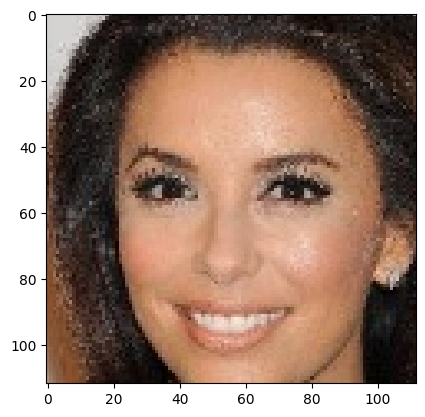

torch.Size([3, 112, 112]) tensor(8) tensor(85)


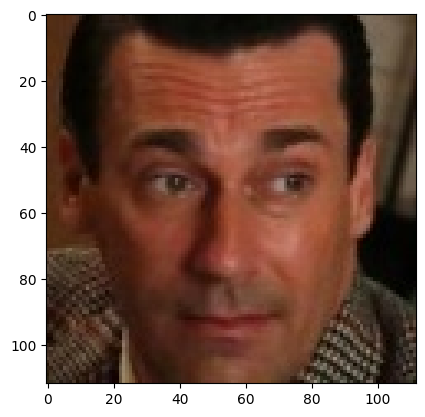

torch.Size([3, 112, 112]) tensor(7) tensor(79)


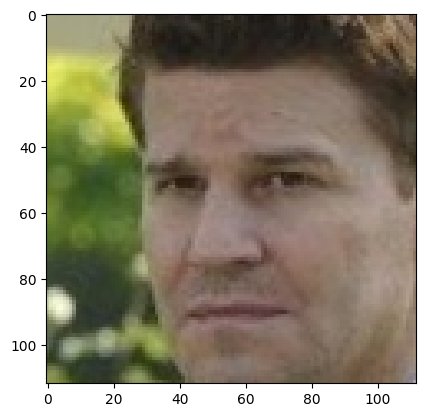

torch.Size([3, 112, 112]) tensor(2) tensor(27)


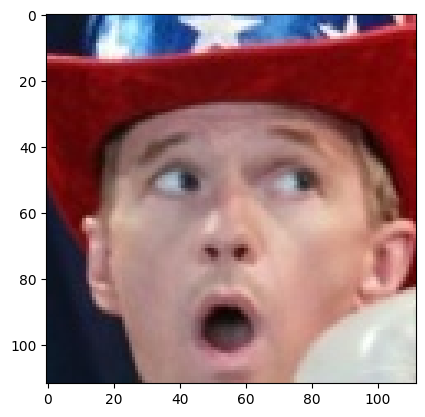

torch.Size([3, 112, 112]) tensor(8) tensor(83)


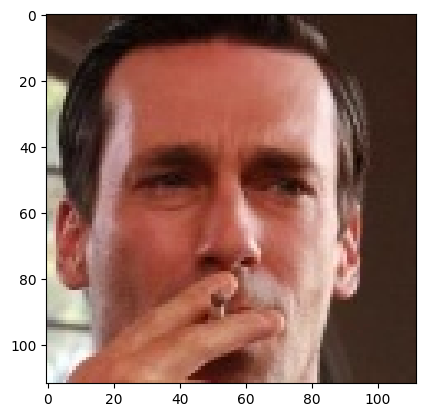

torch.Size([3, 112, 112]) tensor(1) tensor(10)


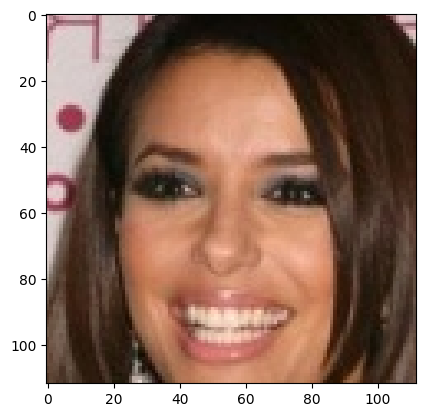

torch.Size([3, 112, 112]) tensor(9) tensor(95)


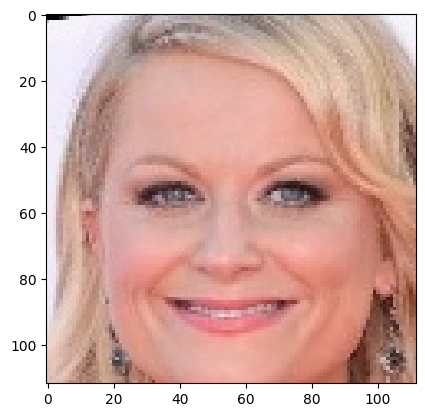

torch.Size([3, 112, 112]) tensor(4) tensor(47)


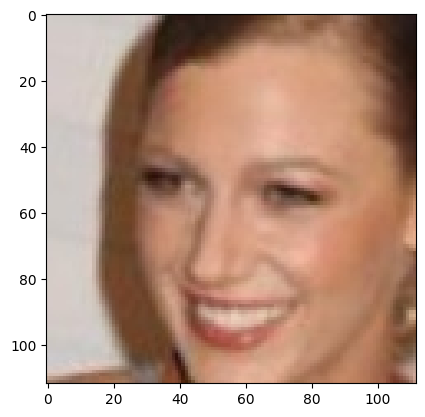

In [5]:
inverse_normalize = transforms.Compose([
    transforms.Normalize(mean = [0., 0., 0.], std = [1/0.5, 1/0.5, 1/0.5]),
    transforms.Normalize(mean = [-0.5, -0.5, -0.5], std = [1., 1., 1.]), 
])

for batch_idx, (x,y,z) in enumerate(dl):
    if batch_idx > 0:
        break
    for i in range(len(x)):
        if i > 10:
            break
        fig, ax = plt.subplots()
        print(x[i].shape, y[i], z[i])
        # show 100 images from first batch using pyplot
        ax.imshow(torch.clip(inverse_normalize(x[i].squeeze()).permute(1, 2, 0), 0, 1))
        plt.show()


In [ ]:
def extract_parameters(backbone: nn.Module, header: nn.Module) -> list:
    """
    Extract the parameters of the model that require gradients and are therefore trainable.
    Args:
        model (nn.Module): The model from which to extract parameters.
    """
    parameters = []

    for layer in list(backbone.children())[0:-2]:
        for param in layer.parameters():
            param.requires_grad_(False)
    parameters += list(backbone.children())[-2].parameters()
    for param in header.parameters():
        if param.requires_grad:
            parameters.append(param)

    return parameters


def load_checkpoint(backbone: nn.Module, header, checkpoint_path: str):
    """
    Load a checkpoint from the specified path and return the learning rate.
    Args:
        model (nn.Module): The model to load the checkpoint into.
        checkpoint_path (str): The path to the checkpoint file.
    Returns:
        learning_rate (float): The learning rate from the checkpoint.
    """

    # Load the checkpoint
    backbone_checkpoint = torch.load(checkpoint_path)
    backbone.load_state_dict(backbone_checkpoint)

    header_checkpoint = torch.load(checkpoint_path.replace('backbone', 'header'))
    header.load_state_dict(header_checkpoint)

    backbone.eval()
    header.eval()
    learning_rate = backbone_checkpoint.get('learning_rate', 1.0)

    # Return the loaded checkpoint
    return learning_rate


def calc_gradients(inputs: torch.Tensor, labels: torch.Tensor):
    params = extract_parameters(backbone, header)

    with torch.autograd.set_grad_enabled(True):
        # Forward pass
        features = backbone(inputs)
        thetas = header(features, labels)
        loss = criterion(thetas, labels)

        assert loss.shape[0] == thetas.shape[0], "Loss and output batch sizes do not match."

        # print("Loss shape:", loss.shape)
        grads_list = [torch.autograd.grad(outputs=loss[i], inputs=thetas, grad_outputs=torch.ones_like(
            loss[i]), retain_graph=True) for i in range(loss.shape[0])]
        # print("gradients list length:", grads_list[0])
        grads = [torch.stack(x) for x in zip(*grads_list)]
        
        return grads

def _tensor_batch_dot(t1: torch.Tensor, t2: torch.Tensor) -> torch.Tensor:
    r"""
    Computes pairwise dot product between two tensors

    Args:
        Tensors t1 and t2 are feature vectors with dimension (batch_size_1, *) and
        (batch_size_2,  *). The * dimensions must match in total number of elements.

    Returns:
        Tensor with shape (batch_size_1, batch_size_2) containing the pairwise dot
        products. For example, Tensor[i][j] would be the dot product between
        t1[i] and t2[j].
    """

    msg = (
        "Please ensure each batch member has the same feature dimension. "
        f"First input has {torch.numel(t1) / t1.shape[0]} features, and "
        f"second input has {torch.numel(t2) / t2.shape[0]} features."
    )
    assert torch.numel(t1) / t1.shape[0] == torch.numel(t2) / t2.shape[0], msg

    return torch.mm(
        t1.view(t1.shape[0], -1),
        t2.view(t2.shape[0], -1).T,
    )

def gradient_dot_product(
    input_grads, src_grads
) -> torch.Tensor:
    r"""
    Computes the dot product between the gradient vector for a model on an input batch
    and src batch, for each pairwise batch member. Gradients are passed in as a tuple
    corresponding to the trainable parameters returned by model.parameters(). Output
    corresponds to a tensor of size (inputs_batch_size, src_batch_size) with all
    pairwise dot products.
    """

    assert len(input_grads) == len(src_grads), "Mismatching gradient parameters."

    iterator = zip(input_grads, src_grads)
    total = _tensor_batch_dot(*next(iterator))
    for input_grad, src_grad in iterator:
        total += _tensor_batch_dot(input_grad, src_grad)

    return total


def checkpoint_contribution(dl: DataLoader, checkpoint_path: str):
    """
    Calculate the contribution of each checkpoint to the model's performance.
    Args:
        dl (DataLoader): DataLoader containing the input data.
        checkpoint_path (str): Path to the checkpoint file.

    Returns:
        checkpoint_contributions (Tensor): A 2D tensor containing the computed contributions for each sample, where checkpoint_contributions[i][j] is the contribution of the j-th checkpoint to the i-th sample.
        all_labels (list): A list containing the labels for each sample.
        all_indices (list): A list containing the indices of each sample in the dataset.
    """
    # Load the checkpoint
    # TODO: use learning rate equation
    learning_rate = load_checkpoint(backbone, header, checkpoint_path)

    all_contributions_list = []
    all_labels = []
    all_indices = []    

    print(len(dl), "batches in dataloader")

    for (outer_samples, outer_labels, outer_indices) in tqdm(dl):
        # calculate gradients for each sample in the batch
        outer_samples = outer_samples.to(device)
        outer_labels = outer_labels.to(device)
        
        outer_gradients = calc_gradients(outer_samples, outer_labels)
        # print("outer gradients:", len(outer_gradients), outer_gradients[0].shape)

        first_few_contributions_list = []
        labels_list = []
        indices_list = []

        for (samples, labels, indices) in dl:
            inputs = samples.to(device)
            labels = labels.to(device)

            gradients = calc_gradients(inputs, labels)

            # print("gradients :", gradients[0])

            first_few_contributions_list.append(
                gradient_dot_product(outer_gradients, gradients) * learning_rate
            )
            labels_list.append(labels.cpu())
            indices_list.append(indices)

        # Concatenate contributions for this batch
        first_few_contributions_tensor = torch.cat(first_few_contributions_list, dim=1)
        labels_tensor = torch.cat(labels_list, dim=0)
        indices_tensor = torch.cat(indices_list, dim=0)

        if (len(all_labels) == 0):
            all_labels = labels_tensor.unsqueeze(0)

        if (len(all_indices) == 0):
            all_indices = indices_tensor.unsqueeze(0)

        all_contributions_list.append(first_few_contributions_tensor)

    # Concatenate all contributions across batches
    all_contributions_tensor = torch.cat(all_contributions_list, dim=0)

    return all_contributions_tensor, all_labels, all_indices

In [7]:
def run_checkpoint_calculation():
    """
    Calculate the contributions of a set of samples checkpoint-wise.

    Returns:
        influence_scores (Tensor): Influence scores as a 2D tensor of shape (num_samples, num_samples), where influence_scores[i][j] indicates the influence of sample j on sample i.
        labels (list): List of labels corresponding to the samples.
        indices (list): List of indices corresponding to the samples.
    """
    checkpoint_paths = [CHECKPOINTS_PATH_FORMAT.format(i * 4790) for i in range(1, 5)]  # use every tenth epoch as a checkpoint to evaluate

    print("Processing checkpoint 0")
    self_infl_scores, labels, indices = checkpoint_contribution(dl, checkpoint_paths[0])

    for idx, path in enumerate(checkpoint_paths[1:]):
        print(f"Processing checkpoint {idx + 1} at {path}")
        if not os.path.exists(path):
            print(f"Checkpoint {path} does not exist, skipping.")
            continue
        
        new_self_infl_scores, _, _ = checkpoint_contribution(dl, path)
        self_infl_scores += new_self_infl_scores

    return self_infl_scores, labels, indices

In [10]:
def main():
    self_influence_scores, labels, indices = run_checkpoint_calculation()

    influence_scores_np = self_influence_scores.cpu().numpy()

    influence_scores_df = pd.DataFrame(influence_scores_np, columns=indices[0].numpy(), index=indices[0].numpy())
    
    influence_scores_df.to_csv('output/influence_scores_new.csv', index=True, header=True, sep=';')


In [ ]:
if __name__ == "__main__":
    main()

Processing checkpoint 0
5 batches in dataloader


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.29it/s]


Processing checkpoint 1 at ../checkpoints/9580backbone.pth
5 batches in dataloader


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.35it/s]


Processing checkpoint 2 at ../checkpoints/14370backbone.pth
5 batches in dataloader


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.36it/s]


Processing checkpoint 3 at ../checkpoints/19160backbone.pth
5 batches in dataloader


100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.38it/s]
